### 17. MONAI deep learning registration with affine pre-alignment using itk-elastix

A global (rigid/affine) registration is often used as a pre-processing step for deep learning applications. This notebook shows how to apply affine pre-alignment using Elastix before local (non-linear) deep learning registration via project MONAI. The pre-aligning registration is calculated only once, and then it is cached allowing for a faster training.

In [1]:
import os
import itk
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from monai.utils import set_determinism
from monai.transforms import MapTransform, Compose, LoadImaged, EnsureChannelFirstD, ScaleIntensityRanged
from monai.data import CacheDataset, ITKReader, DataLoader
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet, LocalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset
from monai.losses import GlobalMutualInformationLoss, BendingEnergyLoss

set_determinism(42)

if torch.cuda.is_available():
    device = "cuda:0"
    max_epochs = 500
else:
    device = "cpu"
    max_epochs=3

print("Device: ", device)

Device:  cuda:0


### Dataset

After downloading the MedNISTDataset, we keep only the x-ray hand images dataset and create random pairs of images (fixed and moving) to register.

In [2]:
# Download MedNISTDataset
root_dir = './'
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)

# Keep only the hand x-rays
hands = [os.path.join(root_dir, item["image"]) for item in train_data.data if item["label"]==4] # label 4 is for xray hands
hands = hands[:1000] # use only a subset of the whole data

# Create a dictionary with random pairs of fixed-moving images 
training_datadict = [
    {"fixed_hand": fixed_hand, "moving_hand": moving_hand}
    for fixed_hand, moving_hand in np.random.choice(hands, size=(len(hands)//2, 2), replace=False)
]

2022-11-23 11:33:08,067 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-23 11:33:08,073 - INFO - File exists: MedNIST.tar.gz, skipped downloading.
2022-11-23 11:33:08,073 - INFO - Non-empty folder exists in MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:00<00:00, 589246.76it/s]


### Elastix affine parameter map

In [3]:
# Elastix affine parameter map
parameter_object = itk.ParameterObject()
affine_parameter_map = parameter_object.GetDefaultParameterMap('affine')
affine_parameter_map['NumberOfResolutions'] = "2"
affine_parameter_map['MaximumNumberOfIterations'] = ("64", )
parameter_object.AddParameterMap(affine_parameter_map)

for key in affine_parameter_map.keys():
    print(key, affine_parameter_map[key])

AutomaticParameterEstimation ('true',)
AutomaticScalesEstimation ('true',)
CheckNumberOfSamples ('true',)
DefaultPixelValue ('0',)
FinalBSplineInterpolationOrder ('3',)
FixedImagePyramid ('FixedSmoothingImagePyramid',)
ImageSampler ('RandomCoordinate',)
Interpolator ('LinearInterpolator',)
MaximumNumberOfIterations ('64',)
MaximumNumberOfSamplingAttempts ('8',)
Metric ('AdvancedMattesMutualInformation',)
MovingImagePyramid ('MovingSmoothingImagePyramid',)
NewSamplesEveryIteration ('true',)
NumberOfResolutions ('2',)
NumberOfSamplesForExactGradient ('4096',)
NumberOfSpatialSamples ('2048',)
Optimizer ('AdaptiveStochasticGradientDescent',)
Registration ('MultiResolutionRegistration',)
ResampleInterpolator ('FinalBSplineInterpolator',)
Resampler ('DefaultResampler',)
ResultImageFormat ('nii',)
Transform ('AffineTransform',)
WriteIterationInfo ('false',)
WriteResultImage ('true',)


### Pre-alignment steps

The custom pre-processing is as follows: 1) Read the images using itk, 2) Register the pairs using Elastix, 3) Convert to numpy array. The rest of the steps are more general (add channel dimension and scale intensities). 

In [4]:
# Pre-processing steps as MONAI transforms
class ITKReadD(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.keys = keys

    def __call__(self, data):
        new_data = dict.fromkeys(self.keys)
        for key in self.keys:
            new_data[key] = itk.imread(data[key], itk.F)
        return new_data


class ElastixPreregistrationD(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.keys = keys

    def __call__(self, data):
        data["aligned_hand"], result_transform_parameters = itk.elastix_registration_method(
                                                                    data[self.keys[0]], data[self.keys[1]],
                                                                    parameter_object=parameter_object,
                                                                    log_to_console=False)
        return data


class ConvertToArrayD(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.keys = keys

    def __call__(self, data):
        for key in self.keys:
            data[key] = itk.GetArrayFromImage(data[key]) 
        return data

keys = ["fixed_hand", "moving_hand", "aligned_hand"]
transforms = Compose([
                        ITKReadD(keys=keys[:2]),
                        ElastixPreregistrationD(keys=keys[:2]),
                        ConvertToArrayD(keys=keys), 
                        EnsureChannelFirstD(keys=keys),
                        ScaleIntensityRanged(keys=keys, a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                     ])

### Perform pre-alignment, and store the calculations

We are using CacheDataset from MONAI to conveniently perform the pre-alignment and store the result. Later during the training loop, directly the already aligned images will be loaded for training of the model.

In [5]:
dataset = CacheDataset(data=training_datadict, transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=16, shuffle=True)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.70it/s]


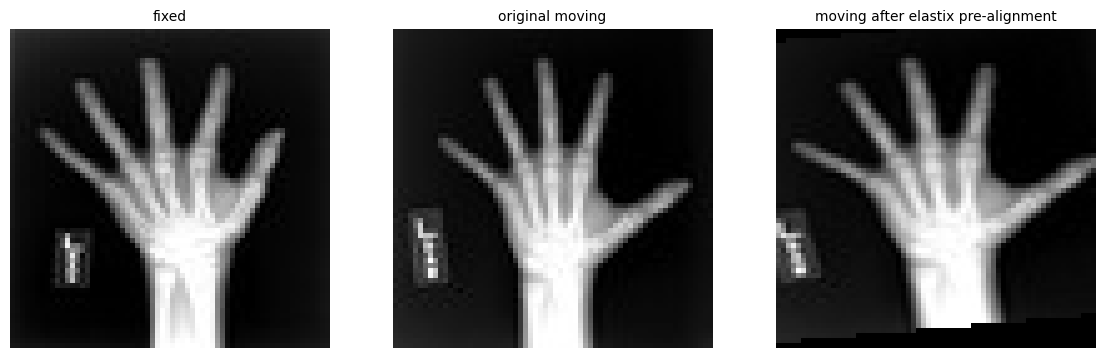

In [6]:
# Show examples of the pre-alignment
fixed, moving, aligned = dataset[0].values()

fig = plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.imshow(fixed.squeeze(), cmap='gray')
plt.title('fixed', fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(moving.squeeze(), cmap='gray')
plt.title('original moving', fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(aligned.squeeze(), cmap='gray')
plt.title('moving after elastix pre-alignment', fontsize=10)
plt.axis('off')
plt.show()

### Deep learning registration model

In [7]:
device = torch.device(device)
    
model = LocalNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=2,
    num_channel_initial=16,
    extract_levels=[0, 1, 2, 3],
    out_activation=None,
    out_kernel_initializer="zeros").to(device)
warp_layer = Warp(mode="bicubic").to(device)
criterion = GlobalMutualInformationLoss()
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


### Training loop

In [8]:
epoch_loss_values = []

for epoch in tqdm(range(max_epochs)):
    model.train()
    epoch_loss = 0
    for i, batch_data in enumerate(dataloader):
        optimizer.zero_grad()

        fixed = batch_data["fixed_hand"].to(device)
        pre_aligned = batch_data["aligned_hand"].to(device)
        ddf = model(torch.cat((pre_aligned, fixed), dim=1))
        pred_image = warp_layer(pre_aligned, ddf)

        loss = criterion(pred_image, fixed) + 0.3*regularization(ddf)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*fixed.shape[0]

    epoch_loss /= len(dataset)
    epoch_loss_values.append(epoch_loss)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:09<00:00,  1.10s/it]


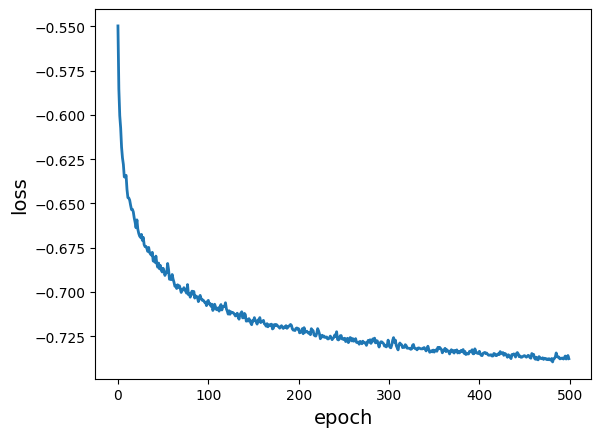

In [9]:
plt.plot(epoch_loss_values, linewidth=2)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.show()

### Visualise example results

For the shake of simplicity we visualise the results in the training set and not in the validation/test set.

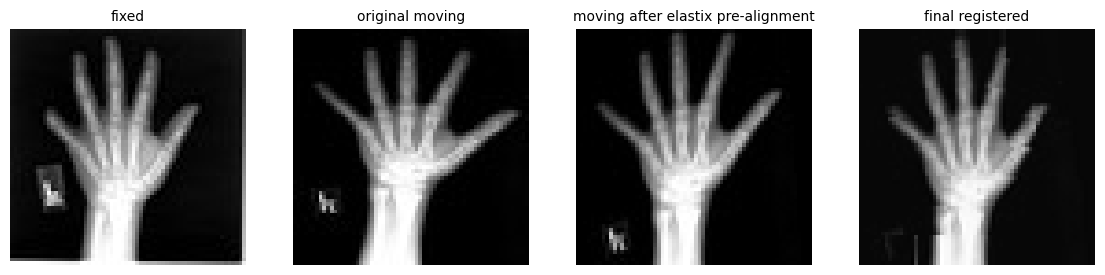

In [10]:
ind = 3
example_fixed = batch_data['fixed_hand'][ind, 0, :, :]
example_moving = batch_data['moving_hand'][ind, 0, :, :]
example_prealigned = batch_data['aligned_hand'][ind, 0, :, :]
example_result = pred_image[ind, 0, :, :].detach().cpu()

fig = plt.figure(figsize=(14, 6))
plt.subplot(1, 4, 1)
plt.imshow(example_fixed, cmap='gray')
plt.title('fixed', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(example_moving, cmap='gray')
plt.title('original moving', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(example_prealigned, cmap='gray')
plt.title('moving after elastix pre-alignment', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(example_result, cmap='gray')
plt.title('final registered', fontsize=10)
plt.axis('off')
plt.show()